# Rank model (group by segment)
Features:
- For merchant itself:
    - revenue level
- For consumer shop at that merchant
    - the average income for the most frequent postcode for each merchant
    - number of consumer
    - proportion of gender (test to be unuseful)
- For transaction take place at that merchant
    - total num of transaction
    - average dollar value

Target:
- total revenue (in rank)

Weight:
- fraud prob (both consumer and merchant)

In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


## Read data

In [179]:
merchant = pd.read_csv('../data/curated/merchant/merchant_clean_segment.csv')
transaction_with_consumer_fraud = pd.read_parquet('../data/curated/transaction/transaction_wcf_after_prediction.parquet')
income_per_postcode = pd.read_csv('../data/external/income_per_postcode.csv')
merchant_fraud = pd.read_csv('../data/curated/merchant/merchant_risk_level.csv')

In [180]:
merchant = merchant.merge(merchant_fraud, on='merchant_abn', how='left')

In [181]:
next_year_avg_dollar = pd.read_csv('../data/predicted/nextyear_pred_avg_dollar.csv')
next_year_consumer = pd.read_csv('../data/predicted/nextyear_pred_consumer_num.csv')
next_year_revenue = pd.read_csv('../data/predicted/nextyear_pred_revenue.csv')
next_year_transaction = pd.read_csv('../data/predicted/nextyear_pred_tran.csv')

In [182]:
next_year = pd.merge(next_year_avg_dollar, next_year_consumer, on='merchant_abn')
next_year = pd.merge(next_year, next_year_revenue, on='merchant_abn')
next_year = pd.merge(next_year, next_year_transaction, on='merchant_abn')
next_year.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)


/var/folders/51/hrjbd3s95q7_fqgml710nj2r0000gn/T/ipykernel_96455/2639549002.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  next_year = pd.merge(next_year, next_year_transaction, on='merchant_abn')


In [183]:
next_year['merchant_abn'] = next_year['merchant_abn']*1000000
next_year["merchant_abn"] = next_year["merchant_abn"].astype(int)

## Generate the statistics for all merchants

In [184]:
def generate_merchant_statistics(df):
    ''' 
    This function is used to generate merchant statistics
    :param df: the dataframe of transaction
    :type df: pandas dataframe
    :return: the dataframe of merchant statistics
    '''
    # found the most common postcode for each merchant
    merchant_postcode = df.groupby("merchant_abn")["postcode"].agg(lambda x:x.value_counts().index[0]).reset_index()

    # the total consumer number for each merchant
    merchant_consumer = df.groupby("merchant_abn")["user_id"].nunique().reset_index()
    merchant_consumer = merchant_consumer.rename(columns={"user_id": "number_of_consumer"})

    # the total transaction number for each merchant
    merchant_transaction = df.groupby("merchant_abn")["dollar_value"].count().reset_index()
    merchant_transaction = merchant_transaction.rename(columns={"dollar_value": "number_of_transaction"})

    # seperate the consumer by gender
    merchant_gender = df.groupby("merchant_abn")["gender"].value_counts().unstack(fill_value=0).reset_index()
    # calculate the percentage of male and female in each merchant
    merchant_gender["Male_Percentage"] = merchant_gender["Male"] / (merchant_gender["Male"] + merchant_gender["Female"] + merchant_gender["Undisclosed"])
    merchant_gender["Female_Percentage"] = merchant_gender["Female"] / (merchant_gender["Male"] + merchant_gender["Female"] + merchant_gender["Undisclosed"])

    # calculate average dollar value
    merchant_dollar_value = df.groupby("merchant_abn")["dollar_value"].mean().reset_index()
    merchant_dollar_value = merchant_dollar_value.rename(columns={"dollar_value": "average_dollar_value"})    

    # calculate total revenue (sum of dollar value*take_rate)
    df["take_amount"] = df["dollar_value"]*df["take_rate"]
    merchant_revenue = df.groupby("merchant_abn")["take_amount"].sum().reset_index()
    merchant_revenue = merchant_revenue.rename(columns={"take_amount": "total_revenue"})

    # calculate the composite weight for each merchant
    weights = {'safe': 0.01, 'unsure': 0, 'fraud': 0.99}
    # count the number of safe, unsure and fraud transactions for each merchant
    merchant_fraud = df.groupby("merchant_abn")['consumer_fraud_probability'].value_counts().unstack(fill_value=0).reset_index()
    merchant_fraud['total_count'] = merchant_fraud[['safe', 'unsure', 'fraud']].sum(axis=1)
    merchant_fraud['composite_weight'] = (
    merchant_fraud['safe'] / merchant_fraud['total_count'] * weights['safe'] +
    merchant_fraud['unsure'] / merchant_fraud['total_count'] * weights['unsure'] +
    merchant_fraud['fraud'] / merchant_fraud['total_count'] * weights['fraud']
    )

    # combine all the statistics together
    result_df = merchant_postcode.merge(merchant_consumer, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_transaction, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_gender, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_dollar_value, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_revenue, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_fraud, on="merchant_abn", how="left")

    return result_df

In [185]:
# generate merchant statistics and merge with income_per_postcode
merchant_statistics = generate_merchant_statistics(transaction_with_consumer_fraud)
merchant_statistics['income_per_postcode'] = merchant_statistics['postcode'].map(income_per_postcode.set_index('Postcode')['Average taxable income or loss'])

# change income_per_postcode to float
merchant_statistics['income_per_postcode'] = merchant_statistics['income_per_postcode'].str.replace(',', '').astype(float)
merchant_statistics

,merchant_abn,postcode,number_of_consumer,number_of_transaction,Female,Male,Undisclosed,Male_Percentage,Female_Percentage,average_dollar_value,total_revenue,fraud,safe,unsure,total_count,composite_weight,income_per_postcode
0,10023283211,5582,3032,3261,1469,1463,329,0.448635,0.450475,215.663205,1.265900e+05,8,3225,28,3261,0.012318,52241.0
1,10142254217,3494,2845,3032,1302,1420,310,0.468338,0.429420,39.035632,4.994625e+05,4,2983,45,3032,0.011144,44513.0
2,10187291046,4417,335,336,147,152,37,0.452381,0.437500,118.136102,1.305924e+05,0,335,1,336,0.009970,44564.0
3,10192359162,6121,383,385,169,182,34,0.472727,0.438961,462.287027,1.126617e+06,0,385,0,385,0.010000,76683.0
4,10206519221,5273,7889,9605,4287,4383,935,0.456325,0.446330,37.295429,2.271131e+06,12,9555,38,9605,0.011185,64947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,99938978285,6467,12385,17443,7855,7796,1792,0.446941,0.450324,30.000574,2.354850e+06,52,17310,81,17443,0.012875,NaN
3678,99974311662,5306,130,130,58,54,18,0.415385,0.446154,294.770198,1.214748e+05,0,130,0,130,0.010000,49249.0
3679,99976658299,4346,14901,23148,10259,10583,2306,0.457189,0.443192,149.774024,2.277799e+07,22,23084,42,23148,0.010913,58489.0
3680,99987905597,2127,189,191,91,87,13,0.455497,0.476440,361.841071,4.713414e+05,0,191,0,191,0.010000,69977.0


In [186]:
merchant_statistics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3682 entries, 0 to 3681
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   merchant_abn           3682 non-null   int64  
 1   postcode               3682 non-null   int64  
 2   number_of_consumer     3682 non-null   int64  
 3   number_of_transaction  3682 non-null   int64  
 4   Female                 3682 non-null   int64  
 5   Male                   3682 non-null   int64  
 6   Undisclosed            3682 non-null   int64  
 7   Male_Percentage        3682 non-null   float64
 8   Female_Percentage      3682 non-null   float64
 9   average_dollar_value   3682 non-null   float64
 10  total_revenue          3682 non-null   float64
 11  fraud                  3682 non-null   int64  
 12  safe                   3682 non-null   int64  
 13  unsure                 3682 non-null   int64  
 14  total_count            3682 non-null   int64  
 15  comp

In [187]:
# add the revenue_level, take_rate column from merchant to merchant_statistics by merchant_abn
merchant["merchant_abn"] = merchant["merchant_abn"].astype("int64")
merchant_statistics["merchant_abn"] = merchant_statistics["merchant_abn"].astype("int64")
merchant_statistics = merchant_statistics.merge(merchant[["merchant_abn", "revenue_level", "take_rate", 'first_word', 'risk_level', 'segment']], on="merchant_abn", how="left")
# add a query id for each merchant for the ranking model to use
merchant_statistics['query_id'] = merchant_statistics['merchant_abn'].astype('category').cat.codes
merchant_statistics


,merchant_abn,postcode,number_of_consumer,number_of_transaction,Female,Male,Undisclosed,Male_Percentage,Female_Percentage,average_dollar_value,...,unsure,total_count,composite_weight,income_per_postcode,revenue_level,take_rate,first_word,risk_level,segment,query_id
0,10023283211,5582,3032,3261,1469,1463,329,0.448635,0.450475,215.663205,...,28,3261,0.012318,52241.0,e,0.18,furniture,1.0,lifestyle,0
1,10142254217,3494,2845,3032,1302,1420,310,0.468338,0.429420,39.035632,...,45,3032,0.011144,44513.0,b,4.22,telecom,1.0,technical,1
2,10187291046,4417,335,336,147,152,37,0.452381,0.437500,118.136102,...,1,336,0.009970,44564.0,b,3.29,jewelry,1.0,accessory,2
3,10192359162,6121,383,385,169,182,34,0.472727,0.438961,462.287027,...,0,385,0.010000,76683.0,a,6.33,music,1.0,entertainment,3
4,10206519221,5273,7889,9605,4287,4383,935,0.456325,0.446330,37.295429,...,38,9605,0.011185,64947.0,a,6.34,gift,1.0,lifestyle,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,99938978285,6467,12385,17443,7855,7796,1792,0.446941,0.450324,30.000574,...,81,17443,0.012875,NaN,b,4.50,optician,1.0,specialty,3677
3678,99974311662,5306,130,130,58,54,18,0.415385,0.446154,294.770198,...,0,130,0.010000,49249.0,b,3.17,book,1.0,entertainment,3678
3679,99976658299,4346,14901,23148,10259,10583,2306,0.457189,0.443192,149.774024,...,42,23148,0.010913,58489.0,a,6.57,shoe,1.0,accessory,3679
3680,99987905597,2127,189,191,91,87,13,0.455497,0.476440,361.841071,...,0,191,0.010000,69977.0,a,6.82,motor,1.0,specialty,3680


In [188]:
# merge the 2023 prediction to merchant_statistics
merchant_statistics_next_year = merchant_statistics.merge(next_year, on="merchant_abn", how="left")

# Get the total revenue rank for this year

In [189]:
merchant_statistics['total_revenue_rank'] = merchant_statistics['total_revenue'].rank(ascending=False, method='max')
merchant_statistics['total_revenue_rank'] = merchant_statistics['total_revenue_rank'].astype('int64')
merchant_statistics['revenue_level'] = le.fit_transform(merchant_statistics['revenue_level'])

merchant_statistics

,merchant_abn,postcode,number_of_consumer,number_of_transaction,Female,Male,Undisclosed,Male_Percentage,Female_Percentage,average_dollar_value,...,total_count,composite_weight,income_per_postcode,revenue_level,take_rate,first_word,risk_level,segment,query_id,total_revenue_rank
0,10023283211,5582,3032,3261,1469,1463,329,0.448635,0.450475,215.663205,...,3261,0.012318,52241.0,4,0.18,furniture,1.0,lifestyle,0,3088
1,10142254217,3494,2845,3032,1302,1420,310,0.468338,0.429420,39.035632,...,3032,0.011144,44513.0,1,4.22,telecom,1.0,technical,1,2027
2,10187291046,4417,335,336,147,152,37,0.452381,0.437500,118.136102,...,336,0.009970,44564.0,1,3.29,jewelry,1.0,accessory,2,3060
3,10192359162,6121,383,385,169,182,34,0.472727,0.438961,462.287027,...,385,0.010000,76683.0,0,6.33,music,1.0,entertainment,3,1450
4,10206519221,5273,7889,9605,4287,4383,935,0.456325,0.446330,37.295429,...,9605,0.011185,64947.0,0,6.34,gift,1.0,lifestyle,4,1017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,99938978285,6467,12385,17443,7855,7796,1792,0.446941,0.450324,30.000574,...,17443,0.012875,NaN,1,4.50,optician,1.0,specialty,3677,989
3678,99974311662,5306,130,130,58,54,18,0.415385,0.446154,294.770198,...,130,0.010000,49249.0,1,3.17,book,1.0,entertainment,3678,3116
3679,99976658299,4346,14901,23148,10259,10583,2306,0.457189,0.443192,149.774024,...,23148,0.010913,58489.0,0,6.57,shoe,1.0,accessory,3679,75
3680,99987905597,2127,189,191,91,87,13,0.455497,0.476440,361.841071,...,191,0.010000,69977.0,0,6.82,motor,1.0,specialty,3680,2061


# LambdaMART model for rank training

In [190]:
# Define the feature columns
feature_columns = ['income_per_postcode', 'number_of_transaction',	'number_of_consumer', 'average_dollar_value', 'Male_Percentage', 'Female_Percentage', 'composite_weight', 'revenue_level']
weight_columns = ['composite_weight']
target_column = 'total_revenue_rank'

In [191]:
def train_xgboost_model(data, target_column, feature_columns, weight_column, random_state=42):
    ''' 
    Train an XGBoost regression model using the provided data and return the model, evaluation results, predictions, and ranking.
    :param data: the data to train the model on
    :type data: pandas.DataFrame
    :param target_column: the name of the target column
    :type target_column: str
    :param feature_columns: the names of the feature columns
    :type feature_columns: list[str]
    :param weight_column: the name of the weight column
    :type weight_column: str
    :param random_state: the random state to use for train test split
    :type random_state: int
    :return: the model, evaluation results, predictions, and ranking
    '''
    epsilon = 1e-5  # prevent small number from being divided by 0

    # train test split
    X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
        data[feature_columns], data[target_column], data[weight_column], test_size=0.2, random_state=random_state)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtrain.set_weight(1 / (weight_train + epsilon))
    dtest = xgb.DMatrix(X_test, label=y_test)
    dtest.set_weight(1 / (weight_test + epsilon))

    # set xgboost parameters
    param = {'objective': 'reg:squarederror', 'eta': 0.1, 'gamma': 1.0, 'min_child_weight': 0.1,
             'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'eval_metric': 'rmse', 
             'n_estimators': 200}
    num_round = 100

    # model training
    evals_result = {}
    bst = xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], early_stopping_rounds=10, evals_result=evals_result)
    y_pred = bst.predict(dtest)
    
    # predict all data for ranking
    ddata = xgb.DMatrix(data[feature_columns])
    all_y_pred = bst.predict(ddata)
    
    # create a dataframe for ranking
    ranking_df = pd.DataFrame({
        'Merchant_ABN': data['merchant_abn'],
        'segment' : data['segment'],
        'postcode': data['postcode'],
        'Actual': data[target_column],
        'Predicted': all_y_pred
    })

    ranking_df = ranking_df.sort_values(by='Predicted', ascending=True).reset_index(drop=True)
    ranking_df.index += 1  # rank from 1 instead of 0
    ranking_df['Predicted_rank'] = ranking_df['Predicted'].rank(ascending=True, method='dense')


    return bst, evals_result, y_pred, y_test, ranking_df

### Grid search for hyper-parameter tuning

In [192]:
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb

# def train_xgboost_model(data, target_column, feature_columns, weight_column, random_state=42):
#     epsilon = 1e-5  

#     # train test split
#     X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
#         data[feature_columns], data[target_column], data[weight_column], test_size=0.2, random_state=random_state)

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtrain.set_weight(1 / (weight_train + epsilon))
#     dtest = xgb.DMatrix(X_test, label=y_test)
#     dtest.set_weight(1 / (weight_test + epsilon))

#     param_grid = {
#         'max_depth': [3, 4, 5, 6],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'n_estimators': [50, 100, 200],
#         'gamma': [0, 1, 2],
#         'min_child_weight': [0.1, 1, 2],
#         'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#         'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#     }

#     xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

#     grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

#     grid_search.fit(X_train, y_train, sample_weight=1 / (weight_train + epsilon))

#     best_params = grid_search.best_params_

#     bst = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', **best_params)
#     bst.fit(X_train, y_train, sample_weight=1 / (weight_train + epsilon))
    
    
#     return bst, evals_result, y_pred, y_test, ranking_df



# Every merchant together (LAST YEAR)

In [193]:
# consider both merhcant and consumer fraud
merchant_statistics['composite_weight'] = merchant_statistics['composite_weight'] * merchant_statistics['risk_level']

In [194]:
# features
feature_columns = ['income_per_postcode', 'number_of_transaction',	'number_of_consumer', 'average_dollar_value', 'revenue_level']
weight_columns = ['composite_weight']
target_column = 'total_revenue_rank'

#### For grid search usage

In [195]:
# best_model, evals_result, y_pred, y_test, ranking_df = train_xgboost_model(merchant_statistics, target_column, feature_columns, weight_columns)

# # 打印最佳模型参数
# print("Best Model Parameters:", best_model.get_params())

#### Model training

In [196]:
bst, evals_result, y_pred, y_test, ranking = train_xgboost_model(merchant_statistics, target_column, feature_columns, 'composite_weight')

[0]	test-rmse:956.54101
[1]	test-rmse:870.98004
[2]	test-rmse:794.89075
[3]	test-rmse:722.94779
[4]	test-rmse:660.28476
[5]	test-rmse:603.07461
[6]	test-rmse:552.55222
[7]	test-rmse:507.36296
[8]	test-rmse:465.74106
[9]	test-rmse:429.66785
[10]	test-rmse:396.01122
[11]	test-rmse:366.65952
[12]	test-rmse:339.98413
[13]	test-rmse:316.29750
[14]	test-rmse:295.38953
[15]	test-rmse:276.19196
[16]	test-rmse:258.88345


[17]	test-rmse:243.78702
[18]	test-rmse:230.97844
[19]	test-rmse:219.55821
[20]	test-rmse:209.62432
[21]	test-rmse:200.95706
[22]	test-rmse:193.15301
[23]	test-rmse:186.05494
[24]	test-rmse:180.12259
[25]	test-rmse:174.44809
[26]	test-rmse:170.23365
[27]	test-rmse:166.05972


/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	test-rmse:162.55281
[29]	test-rmse:159.60123
[30]	test-rmse:157.14559
[31]	test-rmse:154.61022
[32]	test-rmse:152.39577
[33]	test-rmse:150.54233
[34]	test-rmse:148.83658
[35]	test-rmse:147.53787
[36]	test-rmse:146.27396
[37]	test-rmse:145.02635
[38]	test-rmse:143.84586
[39]	test-rmse:143.00242
[40]	test-rmse:142.25782
[41]	test-rmse:141.79553
[42]	test-rmse:140.82241
[43]	test-rmse:140.29930
[44]	test-rmse:139.70693
[45]	test-rmse:139.22178
[46]	test-rmse:138.84861
[47]	test-rmse:138.45488
[48]	test-rmse:138.25511
[49]	test-rmse:138.04202
[50]	test-rmse:137.74132
[51]	test-rmse:137.50976
[52]	test-rmse:137.40965
[53]	test-rmse:137.20014
[54]	test-rmse:137.06859
[55]	test-rmse:136.92159
[56]	test-rmse:136.74114
[57]	test-rmse:136.63065
[58]	test-rmse:136.55610
[59]	test-rmse:136.32816
[60]	test-rmse:136.13927
[61]	test-rmse:136.07317
[62]	test-rmse:136.02851
[63]	test-rmse:135.97894
[64]	test-rmse:135.87479
[65]	test-rmse:135.92849
[66]	test-rmse:136.57547
[67]	test-rmse:136.60049


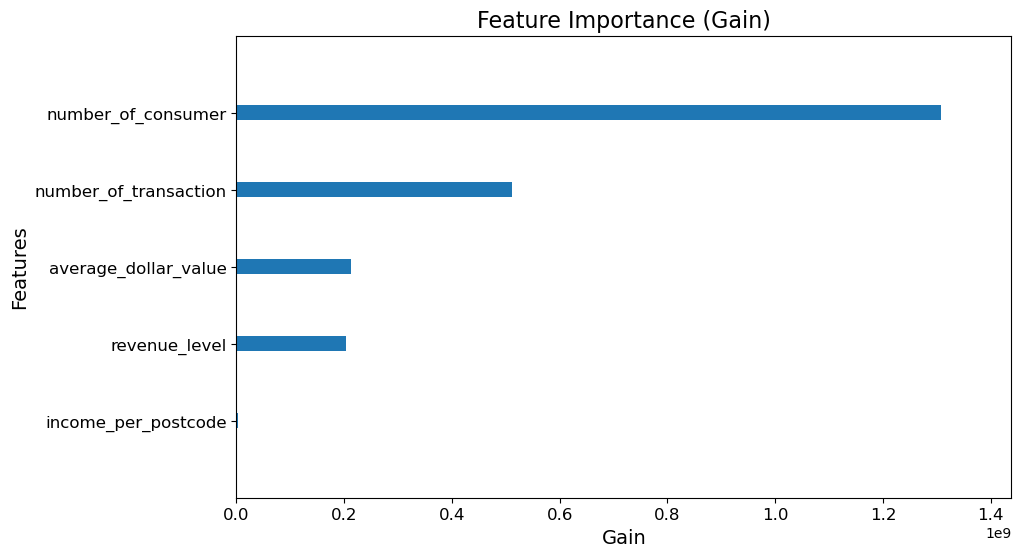

In [197]:
# plot feature importance
xgb.plot_importance(bst, importance_type='gain', title='Feature Importance (Gain)', xlabel='Gain', grid=False, show_values=False)

plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importance (Gain)', fontsize=16)
plt.xlabel('Gain', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


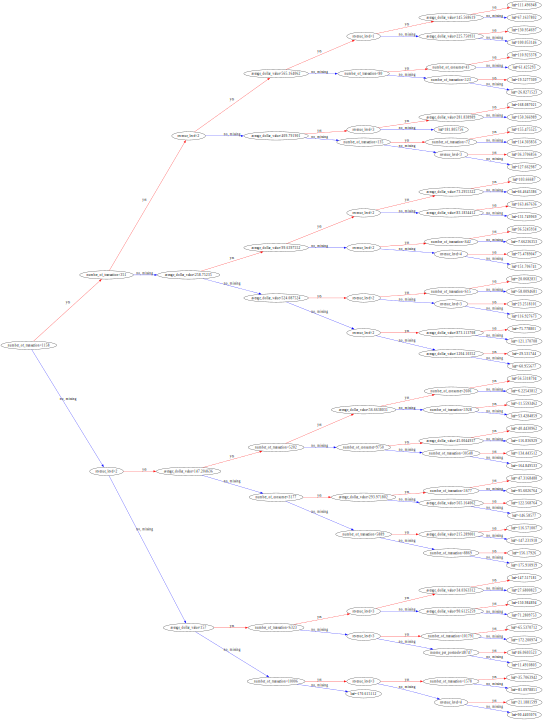

In [198]:
# draw a tree graph as a pdf file
xgb.to_graphviz(bst, num_trees=0, size="10,10", rankdir='LR')



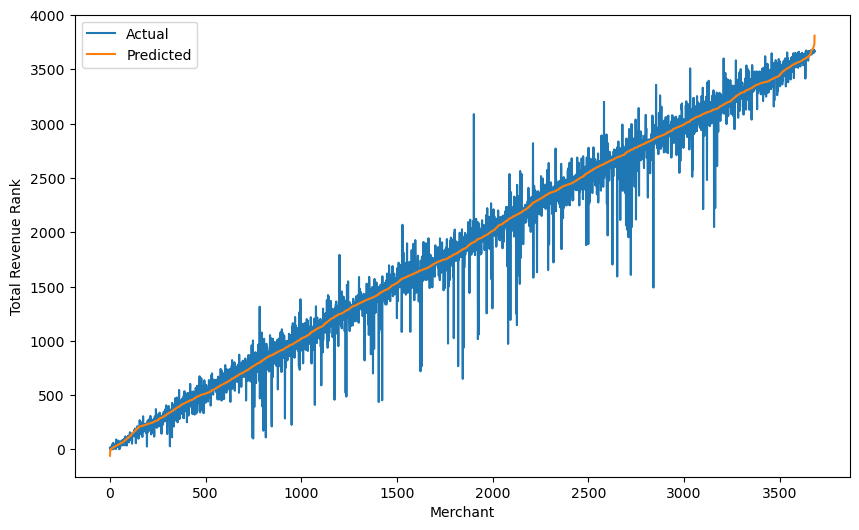

In [199]:
# plot the ranking
plt.plot(ranking.index, ranking['Actual'], label='Actual')
plt.plot(ranking.index, ranking['Predicted'], label='Predicted')
plt.xlabel('Merchant')
plt.ylabel('Total Revenue Rank')
plt.legend()
plt.show()

#### Model performance

In [200]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 31879.7708701925
Mean Absolute Error: 113.76228598435505
R-squared: 0.9710158850626879


#### The predicted rank for last year

In [201]:
ranking

,Merchant_ABN,segment,postcode,Actual,Predicted,Predicted_rank
1,82368304209,technical,3005,11,-57.462296,1.0
2,38700038932,specialty,2604,5,-7.539617,2.0
3,96680767841,specialty,5606,7,-6.478231,3.0
4,80551528183,specialty,4880,22,-1.496533,4.0
5,63123845164,lifestyle,4374,9,-1.338902,5.0
...,...,...,...,...,...,...
3678,96336573256,lifestyle,1130,3673,3711.808105,3625.0
3679,64196096120,lifestyle,4716,3680,3719.903320,3626.0
3680,82882476966,technical,6968,3654,3722.719727,3627.0
3681,79008028287,technical,1819,3676,3725.495605,3628.0


## Every merchant together (THIS YEAR)

In [202]:
merchant_statistics_next_year['revenue_level'] = le.fit_transform(merchant_statistics_next_year['revenue_level'])

merchant_statistics_next_year

,merchant_abn,postcode,number_of_consumer,number_of_transaction,Female,Male,Undisclosed,Male_Percentage,Female_Percentage,average_dollar_value,...,revenue_level,take_rate,first_word,risk_level,segment,query_id,Predicted Avg Dollar,Predicted Consumer Number,Predicted revenue,Predicted Transaction Number
0,10023283211,5582,3032,3261,1469,1463,329,0.448635,0.450475,215.663205,...,4,0.18,furniture,1.0,lifestyle,0,215.981013,3018.559464,1.533194e+06,3484.506000
1,10142254217,3494,2845,3032,1302,1420,310,0.468338,0.429420,39.035632,...,1,4.22,telecom,1.0,technical,1,38.716586,2820.403593,4.741837e+05,3108.495600
2,10187291046,4417,335,336,147,152,37,0.452381,0.437500,118.136102,...,1,3.29,jewelry,1.0,accessory,2,116.774819,399.356656,1.842250e+05,349.327400
3,10192359162,6121,383,385,169,182,34,0.472727,0.438961,462.287027,...,0,6.33,music,1.0,entertainment,3,479.917474,389.869413,1.134313e+06,400.975560
4,10206519221,5273,7889,9605,4287,4383,935,0.456325,0.446330,37.295429,...,0,6.34,gift,1.0,lifestyle,4,37.213071,7883.547850,2.393028e+06,10578.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,99938978285,6467,12385,17443,7855,7796,1792,0.446941,0.450324,30.000574,...,1,4.50,optician,1.0,specialty,3677,30.161008,12535.662071,2.377972e+06,15432.722000
3678,99974311662,5306,130,130,58,54,18,0.415385,0.446154,294.770198,...,1,3.17,book,1.0,entertainment,3678,306.845980,208.931115,1.649007e+05,141.536400
3679,99976658299,4346,14901,23148,10259,10583,2306,0.457189,0.443192,149.774024,...,0,6.57,shoe,1.0,accessory,3679,150.635490,15504.729451,1.900765e+07,20520.244000
3680,99987905597,2127,189,191,91,87,13,0.455497,0.476440,361.841071,...,0,6.82,motor,1.0,specialty,3680,363.406096,207.972488,4.272877e+05,181.533160


In [203]:
merchant_statistics_next_year['average_dollar_value'] = merchant_statistics_next_year['Predicted Avg Dollar']
merchant_statistics_next_year['number_of_consumer'] = merchant_statistics_next_year['Predicted Consumer Number']
merchant_statistics_next_year['number_of_transaction'] = merchant_statistics_next_year['Predicted Transaction Number']


#### Fit into the model generate using last year's data

In [204]:
all_y_pred = bst.predict(xgb.DMatrix(merchant_statistics_next_year[feature_columns]))
# create a dataframe for ranking
ranking_df = pd.DataFrame({
    'Merchant_ABN': merchant_statistics_next_year['merchant_abn'],
    'segment' : merchant_statistics_next_year['segment'],
    'postcode': merchant_statistics_next_year['postcode'],
    'Predicted': all_y_pred
})

ranking_next_year = ranking_df.sort_values(by='Predicted', ascending=True).reset_index(drop=True)
ranking_next_year.index += 1 

### Outcome plotting

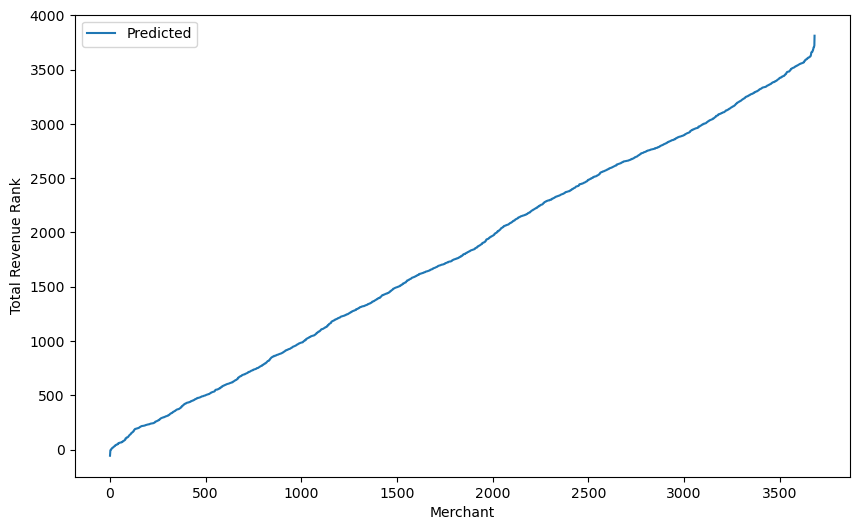

In [205]:
# plot the ranking
plt.plot(ranking_next_year.index, ranking_next_year['Predicted'], label='Predicted')
plt.xlabel('Merchant')
plt.ylabel('Total Revenue Rank')
plt.legend()
plt.show()

# Result analysis and plotting

### Last year

In [206]:
# change predicted rank to int
ranking['Predicted_rank'] = ranking['Predicted_rank'].astype('int64')

In [207]:
# Top 100 for last year
top_100 = ranking.head(100)

### This year

In [208]:
ranking_next_year["Predicted_rank_next"] = ranking_next_year['Predicted'].rank(ascending=True, method='dense')
ranking_next_year["Predicted_rank_next"] = ranking_next_year["Predicted_rank_next"].astype('int64')

### Top 100 by segment

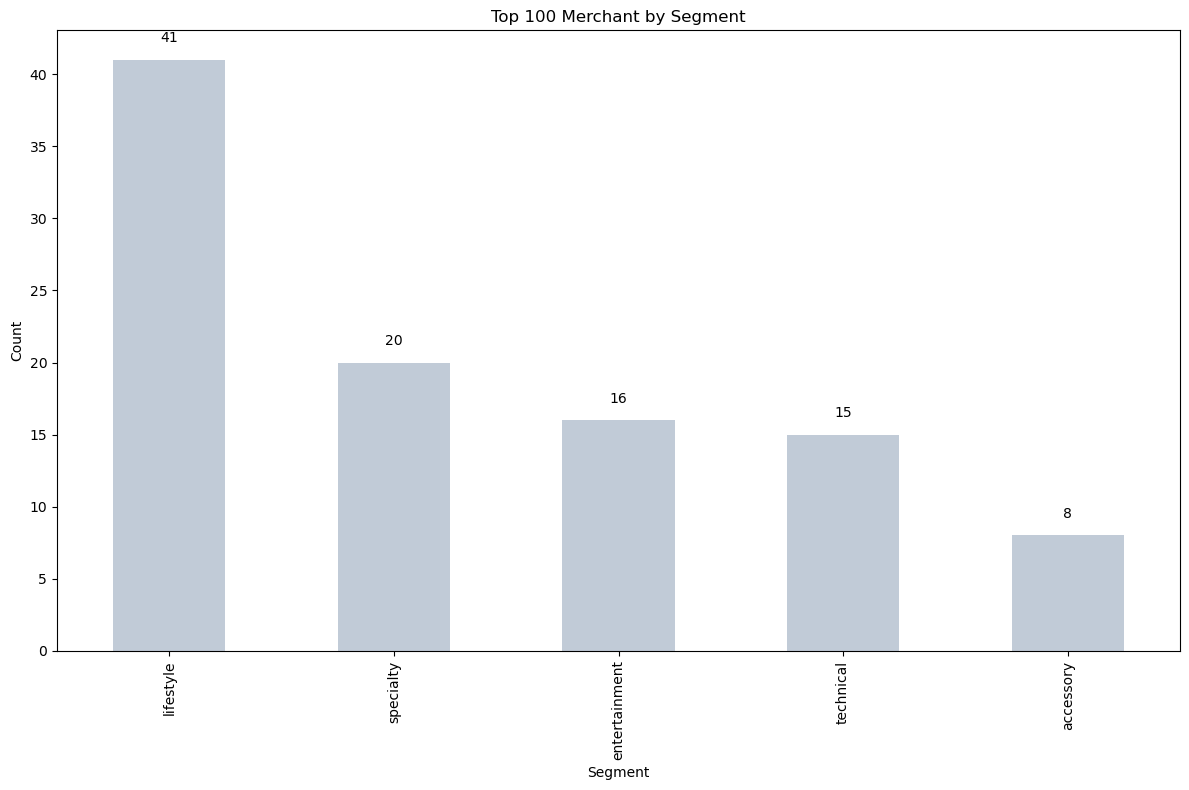

In [209]:
# Top 100 for this year
top_100_merchant = ranking_next_year.head(100)
segment_counts = top_100_merchant['segment'].value_counts()

plt.figure(figsize=(12, 8))
ax = segment_counts.plot(kind='bar', color='#c1cbd7')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.title('Top 100 Merchant by Segment')

# Add the actual count as text labels on top of each bar
for i, count in enumerate(segment_counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [210]:
segment_counts

lifestyle        41
specialty        20
entertainment    16
technical        15
accessory         8
Name: segment, dtype: int64

In [211]:
top_100_merchant

,Merchant_ABN,segment,postcode,Predicted,Predicted_rank_next
1,82368304209,technical,3005,-57.197289,1
2,38700038932,specialty,2604,-21.799095,2
3,98166254020,lifestyle,6385,-6.616046,3
4,96680767841,specialty,5606,-6.478231,4
5,40515428545,lifestyle,5011,-4.218181,5
...,...,...,...,...,...
96,52959528548,lifestyle,3415,117.524200,94
97,38012560280,lifestyle,6467,119.561165,95
98,45946543693,lifestyle,6574,121.405052,96
99,83690644458,lifestyle,2538,125.255684,97


### Top 100 merchant by tags

/var/folders/51/hrjbd3s95q7_fqgml710nj2r0000gn/T/ipykernel_96455/3976614508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100_merchant['first_word'] = top_100_merchant['Merchant_ABN'].map(merchant_statistics_next_year.set_index('merchant_abn')['first_word'])


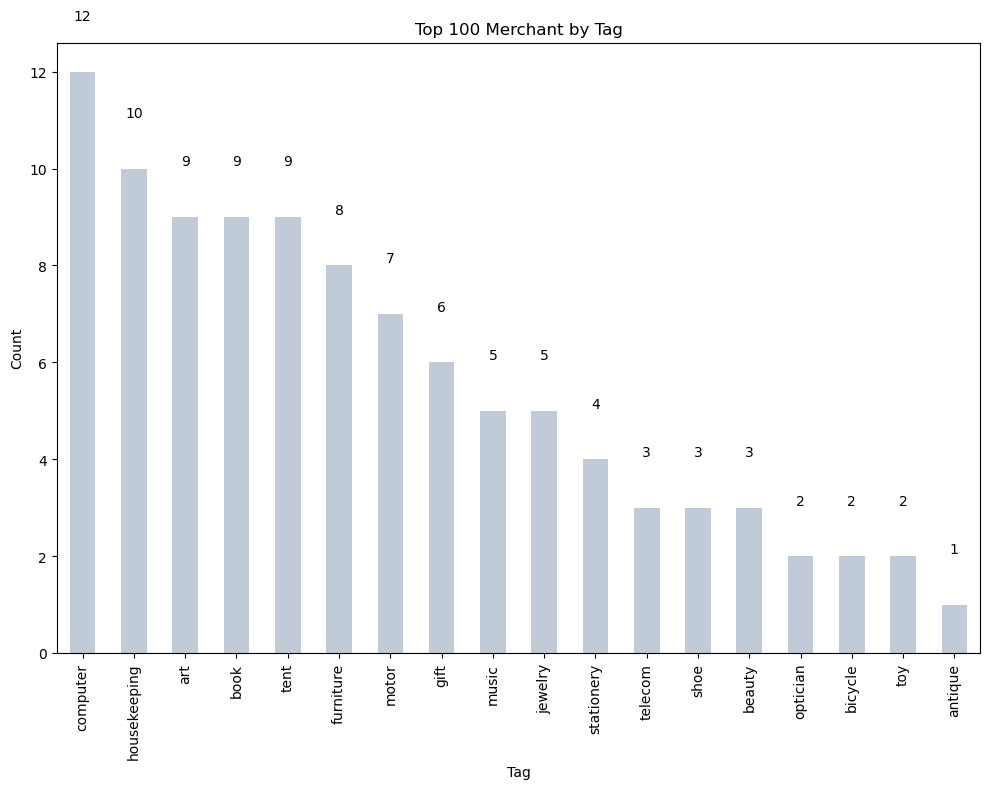

In [212]:
# plot the first_word and segment for each merchant in top_100_merchant
top_100_merchant['first_word'] = top_100_merchant['Merchant_ABN'].map(merchant_statistics_next_year.set_index('merchant_abn')['first_word'])

firstword_count = top_100_merchant['first_word'].value_counts()

plt.figure(figsize=(10, 8))
ax = firstword_count.plot(kind='bar', color='#c1cbd7')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Top 100 Merchant by Tag')

# Add the actual count as text labels on top of each bar
for i, count in enumerate(firstword_count):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [213]:
firstword_count

computer        12
housekeeping    10
art              9
book             9
tent             9
furniture        8
motor            7
gift             6
music            5
jewelry          5
stationery       4
telecom          3
shoe             3
beauty           3
optician         2
bicycle          2
toy              2
antique          1
Name: first_word, dtype: int64

## Compare rank for this year and last year for trend analysis

In [214]:
# compare top_100 and top_100_merchant different in Merchant_ABN
top_100_merchant = ranking_next_year.head(100)
top_100 = ranking.head(100)
top_100_merchant['Merchant_ABN'] = top_100_merchant['Merchant_ABN'].astype('int64')
top_100['Merchant_ABN'] = top_100['Merchant_ABN'].astype('int64')
top_100_merchant['segment'] = top_100_merchant['segment'].astype('category')
top_100['segment'] = top_100['segment'].astype('category')
top_100_merchant = top_100_merchant.merge(top_100[['Merchant_ABN', 'segment']], on='Merchant_ABN', how='left')
top_100_merchant['segment_y'].value_counts()


/var/folders/51/hrjbd3s95q7_fqgml710nj2r0000gn/T/ipykernel_96455/890634568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100_merchant['Merchant_ABN'] = top_100_merchant['Merchant_ABN'].astype('int64')
/var/folders/51/hrjbd3s95q7_fqgml710nj2r0000gn/T/ipykernel_96455/890634568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100['Merchant_ABN'] = top_100['Merchant_ABN'].astype('int64')
/var/folders/51/hrjbd3s95q7_fqgml710nj2r0000gn/T/ipykernel_96455/890634568.py:6: SettingWithCopyWarning: 
A 

lifestyle        33
specialty        20
entertainment    15
technical        12
accessory         8
Name: segment_y, dtype: int64

In [215]:
# print na in top_100_merchant

top_100_merchant[top_100_merchant['segment_y'].isna()]


,Merchant_ABN,segment_x,postcode,Predicted,Predicted_rank_next,segment_y
7,32709545238,lifestyle,5606,5.124264,8,NaN
16,28057731482,entertainment,5713,18.888222,17,NaN
47,43127814599,lifestyle,7017,60.570244,47,NaN
60,61080648284,lifestyle,6969,65.481781,60,NaN
65,16058191622,lifestyle,3070,70.061188,65,NaN
84,16288327194,technical,4215,102.856003,84,NaN
88,78760357380,technical,3415,110.980537,88,NaN
91,35809331583,lifestyle,3558,112.076149,90,NaN
92,41271931352,technical,1819,113.007675,91,NaN
96,38012560280,lifestyle,6467,119.561165,95,NaN


In [216]:
top_100

,Merchant_ABN,segment,postcode,Actual,Predicted,Predicted_rank
1,82368304209,technical,3005,11,-57.462296,1
2,38700038932,specialty,2604,5,-7.539617,2
3,96680767841,specialty,5606,7,-6.478231,3
4,80551528183,specialty,4880,22,-1.496533,4
5,63123845164,lifestyle,4374,9,-1.338902,5
...,...,...,...,...,...,...
96,94455880010,technical,3415,96,107.284599,94
97,13812221471,entertainment,4815,128,112.835342,95
98,46804135891,specialty,1819,84,112.998276,96
99,24852446429,lifestyle,6470,65,112.998276,96


#### Geospatial plot

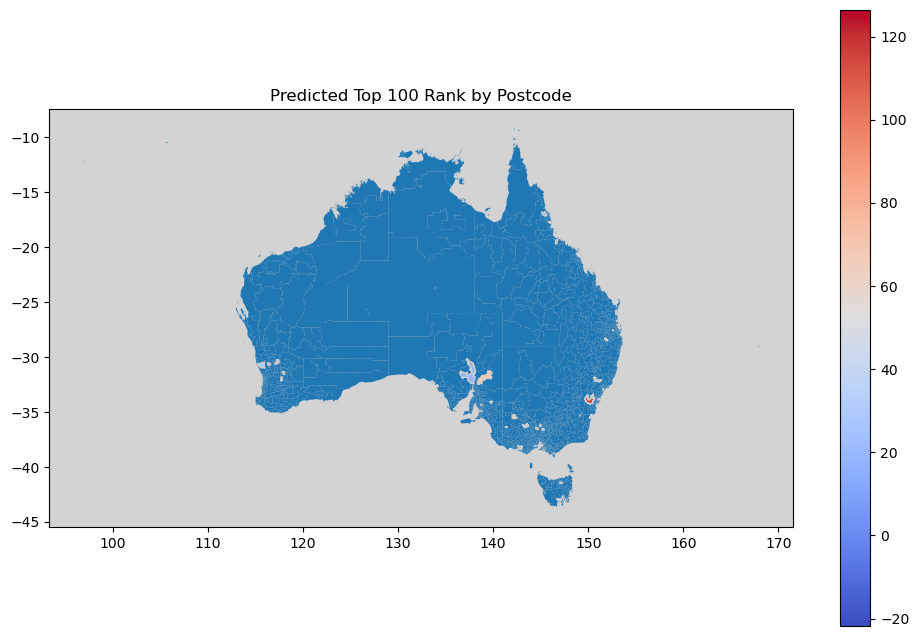

In [217]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

gdf = gpd.read_file("../data/external/POA_2021_AUST_GDA2020_SHP")  
postcode_data = top_100_merchant 

postcode_data['postcode'] = postcode_data['postcode'].astype(str)
top_100_merchant['postcode'] = top_100_merchant['postcode'].astype(str)

merged_data = gdf.merge(postcode_data, left_on='POA_CODE21', right_on='postcode')

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor("lightgray")  # background color

gdf.plot(ax=ax)

merged_data.plot(column="Predicted", cmap="coolwarm", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

ax.set_title("Predicted Top 100 Rank by Postcode")
plt.show()

In [218]:
top_100_merchant['postcode'].sort_index().value_counts()

1819    9
6470    8
4215    6
3415    5
5321    4
7320    4
2336    3
6467    2
6385    2
5606    2
2538    2
4856    2
2519    2
3194    2
3491    2
4511    1
2062    1
4346    1
3070    1
2112    1
3621    1
5432    1
4556    1
6969    1
3005    1
8045    1
2500    1
3265    1
7017    1
4580    1
1021    1
1003    1
4815    1
3558    1
2787    1
6574    1
5410    1
5139    1
3610    1
6991    1
5011    1
4374    1
3201    1
4880    1
5713    1
2141    1
3525    1
5075    1
6507    1
6412    1
7250    1
3214    1
3174    1
4029    1
2604    1
2890    1
2515    1
3015    1
7109    1
2278    1
Name: postcode, dtype: int64

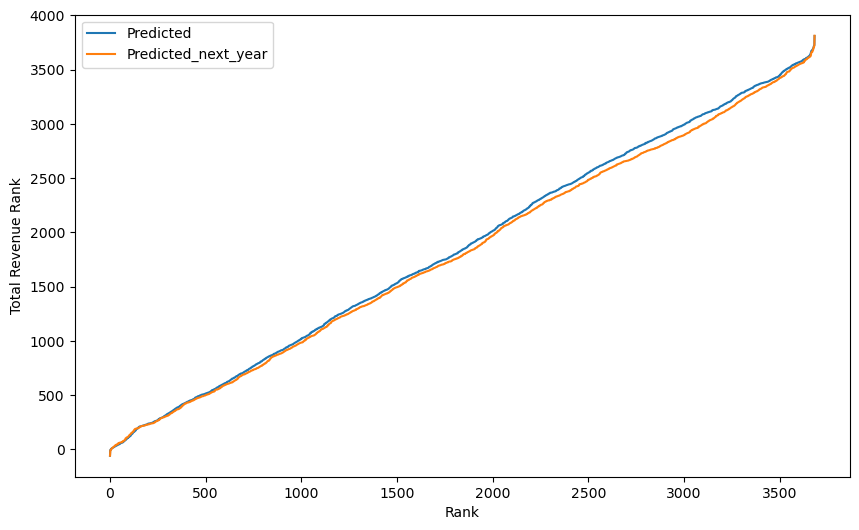

In [219]:
# compare the rank of last year and this year
plt.plot(ranking.index, ranking['Predicted'], label='Predicted')
plt.plot(ranking_next_year.index, ranking_next_year['Predicted'], label='Predicted_next_year')
plt.xlabel('Rank')
plt.ylabel('Total Revenue Rank')
plt.legend()
plt.show()

## Trend Analysis

In [220]:
# merge merchant name from merchant to top_100_merchant
top_100_merchant['merchant name'] = top_100_merchant['Merchant_ABN'].map(merchant.set_index('merchant_abn')['name'])
top_100_merchant['tag'] = top_100_merchant['Merchant_ABN'].map(merchant.set_index('merchant_abn')['first_word'])

In [221]:
draw = top_100_merchant[['merchant name', 'postcode', 'Predicted_rank_next', 'tag', 'segment_x']].head(40)

In [222]:
current_year_rank = top_100_merchant
last_year_rank = top_100

# merge this year and last year rank
merged_rank_df = pd.merge(current_year_rank, last_year_rank, on='Merchant_ABN', suffixes=('_this_year', '_last_year'))

# calculate the rank change
merged_rank_df['Rank_Change'] = merged_rank_df['Predicted_rank_next'] - merged_rank_df['Predicted_rank']

# merchants that dropped out of top 100
dropped_out_merchants = last_year_rank[~last_year_rank['Merchant_ABN'].isin(current_year_rank['Merchant_ABN'])]

# read the segment information
segment_info = dropped_out_merchants[['Merchant_ABN', 'segment']]

# print the segment information for dropped out merchants
print(segment_info)

    Merchant_ABN    segment
26   89726005175  specialty
32   86578477987  accessory
42   43186523025  lifestyle
44   49891706470  specialty
52   45629217853  lifestyle
55   63290521567  lifestyle
84   68216911708  technical
90   18158387243  lifestyle
94   71528203369  accessory
96   94455880010  technical
98   46804135891  specialty
99   24852446429  lifestyle


In [223]:
merged_rank_df

,Merchant_ABN,segment_x,postcode_this_year,Predicted_this_year,Predicted_rank_next,segment_y,merchant name,tag,segment,postcode_last_year,Actual,Predicted_last_year,Predicted_rank,Rank_Change
0,82368304209,technical,3005,-57.197289,1,technical,Nec Incorporated,telecom,technical,3005,11,-57.462296,1,0
1,38700038932,specialty,2604,-21.799095,2,specialty,Etiam Bibendum Industries,tent,specialty,2604,5,-7.539617,2,0
2,98166254020,lifestyle,6385,-6.616046,3,lifestyle,Magna Sed Industries,art,lifestyle,6385,20,3.763451,6,-3
3,96680767841,specialty,5606,-6.478231,4,specialty,Ornare Limited,motor,specialty,5606,7,-6.478231,3,1
4,40515428545,lifestyle,5011,-4.218181,5,lifestyle,Elit Sed Consequat Associates,art,lifestyle,5011,15,6.607697,8,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,29616684420,accessory,1819,112.053360,89,accessory,Tellus Id LLC,jewelry,accessory,1819,117,105.720825,91,-2
84,77590625261,technical,1819,113.819984,92,technical,Sed Diam Foundation,computer,technical,1819,69,79.672783,75,17
85,57699602880,lifestyle,2787,115.048225,93,lifestyle,Tellus Id Institute,stationery,lifestyle,2787,104,115.037056,97,-4
86,52959528548,lifestyle,3415,117.524200,94,lifestyle,Libero Et Limited,furniture,lifestyle,3415,114,92.579971,85,9


In [224]:
merged_rank_df[['Merchant_ABN', 'Rank_Change', 'segment']]

,Merchant_ABN,Rank_Change,segment
0,82368304209,0,technical
1,38700038932,0,specialty
2,98166254020,-3,lifestyle
3,96680767841,1,specialty
4,40515428545,-3,lifestyle
...,...,...,...
83,29616684420,-2,accessory
84,77590625261,17,technical
85,57699602880,-4,lifestyle
86,52959528548,9,lifestyle


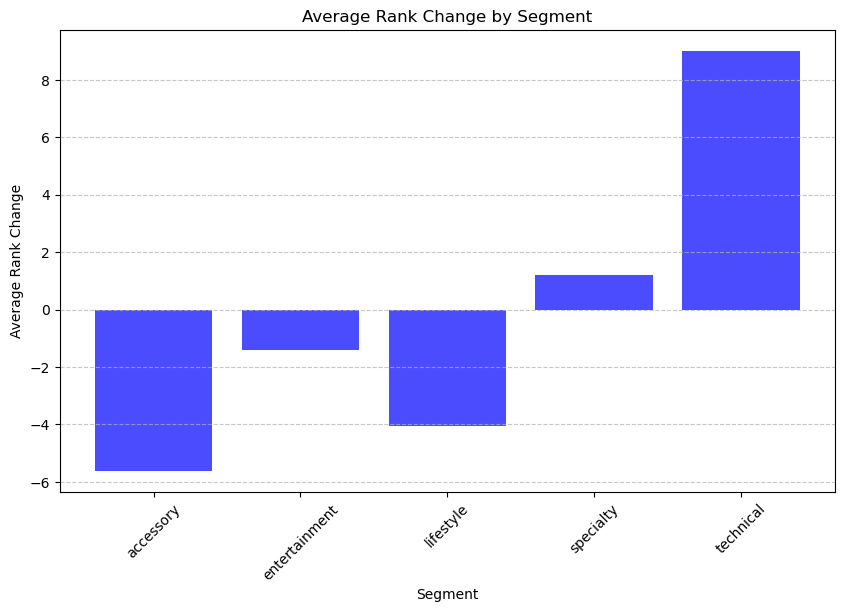

In [225]:
segment_rank_change = merged_rank_df.groupby('segment')['Rank_Change'].mean().reset_index()

# plot the average rank change for each segment
plt.figure(figsize=(10, 6))
plt.bar(segment_rank_change['segment'], segment_rank_change['Rank_Change'], color='b', alpha=0.7)
plt.xlabel('Segment')
plt.ylabel('Average Rank Change')
plt.title('Average Rank Change by Segment')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [226]:
segment_rank_change[['segment', 'Rank_Change']]

,segment,Rank_Change
0,accessory,-5.625000
1,entertainment,-1.400000
2,lifestyle,-4.060606
3,specialty,1.200000
4,technical,9.000000


In [227]:
# draw an average total revenue of merchants for each segment
merchant_revenue_100 = top_100_merchant[['Merchant_ABN', 'segment_x']]
merchant_revenue = ranking_next_year[['Merchant_ABN', 'segment']]
merchant_revenue_100 = merchant_revenue_100.merge(merchant_statistics_next_year, left_on='Merchant_ABN', right_on='merchant_abn', how='left')
merchant_revenue = merchant_revenue.merge(merchant_statistics_next_year, left_on='Merchant_ABN', right_on='merchant_abn', how='left')

In [228]:
next_year['Predicted revenue'].mean()

2270374.809825622

### Average total revenue for each segment with top 100 and with all merchants

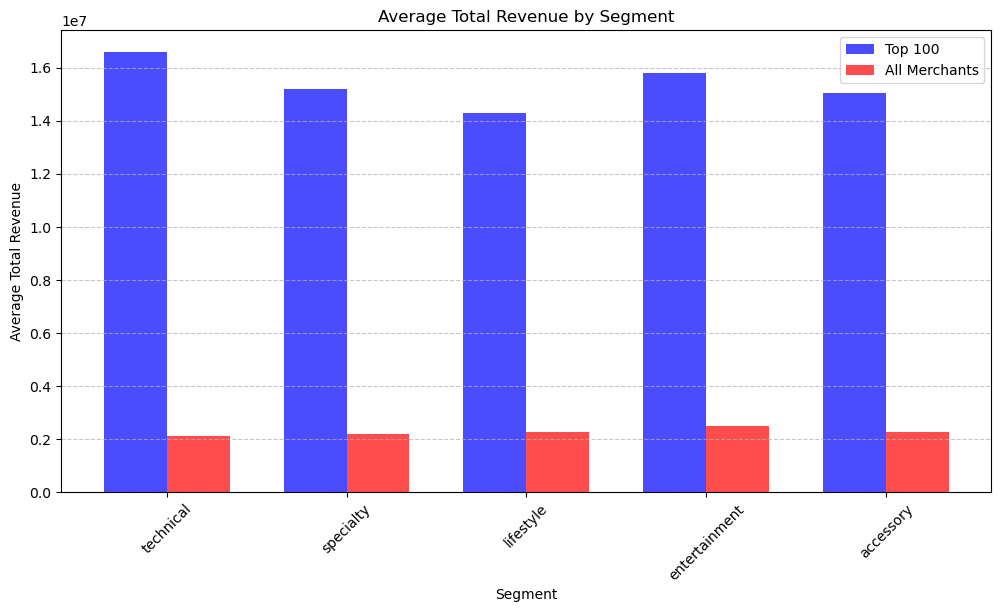

In [229]:
segments = merchant_revenue_100['segment_x'].unique()
top_100_revenue = merchant_revenue_100.groupby('segment_x')['Predicted revenue'].mean()
all_merchants_revenue = merchant_revenue.groupby('segment_x')['Predicted revenue'].mean()

bar_width = 0.35

x = np.arange(len(segments))

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, top_100_revenue, bar_width, color='b', alpha=0.7, label='Top 100')
plt.bar(x + bar_width/2, all_merchants_revenue, bar_width, color='r', alpha=0.7, label='All Merchants')

plt.xlabel('Segment')
plt.ylabel('Average Total Revenue')
plt.title('Average Total Revenue by Segment')
plt.xticks(x, segments, rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()




In [230]:
top_100_revenue

segment_x
accessory        1.658415e+07
entertainment    1.520401e+07
lifestyle        1.429058e+07
specialty        1.580243e+07
technical        1.503062e+07
Name: Predicted revenue, dtype: float64

In [231]:
all_merchants_revenue

segment_x
accessory        2.104250e+06
entertainment    2.200531e+06
lifestyle        2.253240e+06
specialty        2.500522e+06
technical        2.262054e+06
Name: Predicted revenue, dtype: float64